# Response Factor Method for Solving Wall Heat Transfer
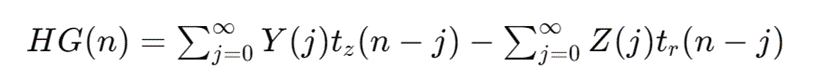

Step [1/200], Val Loss: 1.3025
Step [2/200], Val Loss: 1.3010
Step [3/200], Val Loss: 1.2995
Step [4/200], Val Loss: 1.2979
Step [5/200], Val Loss: 1.2964
Step [6/200], Val Loss: 1.2949
Step [7/200], Val Loss: 1.2934
Step [8/200], Val Loss: 1.2918
Step [9/200], Val Loss: 1.2903
Step [10/200], Val Loss: 1.2888
Step [11/200], Val Loss: 1.2873
Step [12/200], Val Loss: 1.2858
Step [13/200], Val Loss: 1.2842
Step [14/200], Val Loss: 1.2827
Step [15/200], Val Loss: 1.2812
Step [16/200], Val Loss: 1.2797
Step [17/200], Val Loss: 1.2782
Step [18/200], Val Loss: 1.2767
Step [19/200], Val Loss: 1.2752
Step [20/200], Val Loss: 1.2737
Step [21/200], Val Loss: 1.2722
Step [22/200], Val Loss: 1.2706
Step [23/200], Val Loss: 1.2691
Step [24/200], Val Loss: 1.2676
Step [25/200], Val Loss: 1.2661
Step [26/200], Val Loss: 1.2646
Step [27/200], Val Loss: 1.2631
Step [28/200], Val Loss: 1.2616
Step [29/200], Val Loss: 1.2601
Step [30/200], Val Loss: 1.2586
Step [31/200], Val Loss: 1.2571
Step [32/200], Va

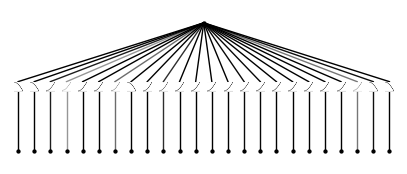

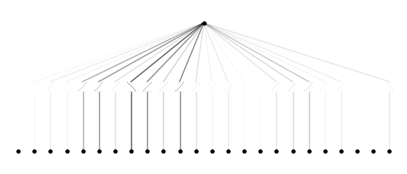

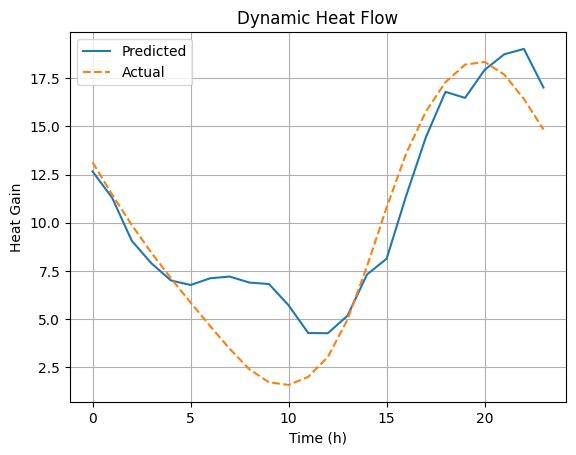

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 确保有 kan 模块

# 原始温度数据
temperatures = np.array([
    23.6, 23.3, 22.8, 22.5, 21.6, 21.6036, 22.08889, 25.57658, 26.88138,
    29.55627, 32.11253, 39.96427, 40.54804, 39.77658, 37.8, 34.32742, 35.07658,
    31.87538, 28.31471, 25.5, 24.6, 24, 23.7, 23.5
])

Heat_gain = np.array([
    13.13417462, 11.45466848, 9.88092101, 8.44516898, 7.11001838, 5.85620446,
    4.6322065, 3.4494772, 2.3910986, 1.72081328, 1.58218798, 2.00155233,
    3.03068612, 4.96438852, 7.74338952, 10.78902253, 13.60305654, 15.76344484,
    17.2882535, 18.20046696, 18.34008677, 17.682225, 16.42127091, 14.83681394
])

temperatures = np.tile(temperatures, 2)
Heat_gain = np.tile(Heat_gain, 2)



# 将温度数据转换为DataFrame
data = pd.DataFrame({'temperatures': temperatures})

# 调整滞后特征数量
N = 24  # 例如将滞后特征减少一半，确保有足够的数据点

# 生成时滞数据
for lag in range(1, N+1):
    data[f'Otemperatures_lag_{lag}'] = data['temperatures'].shift(lag)

# 删除因为时滞而产生的NaN行
data.dropna(inplace=True)

# 检查 data 是否仍然有效
if data.empty:
    print("Data is still empty after dropna(), consider further reducing lag value or modify data handling.")
else:
    # 继续后续处理
    input_features = [f'Otemperatures_lag_{i}' for i in range(1, N+1)]
    x_data = data[input_features].values  # 输入数据
    y_data = Heat_gain[:len(x_data)]  # 修正输出数据的长度以匹配输入数据

    # 后续的代码
    # Normalize the data
    x_mean = np.mean(x_data, axis=0)
    x_std = np.std(x_data, axis=0) + 1e-8
    x_data_norm = (x_data - x_mean) / x_std
    y_mean = np.mean(y_data)
    y_std = np.std(y_data) + 1e-8
    y_data_norm = (y_data - y_mean) / y_std

    # Convert to tensors
    x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)


# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize KAN with adjusted parameters
model = KAN(width=[x_data.shape[1], 1], grid=20, k=5, seed=0)

# Plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}')    

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')



# Train the model with early stopping and learning rate scheduling
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)



#Plot trained KAN
model.plot()
#Automatically set activation functions to be symbolic
# lib = ['x', 'sin', 'exp']
lib = ['x']
model.auto_symbolic(lib=lib)



#Continue training to almost machine precision
train_kan_with_early_stopping(model, dataset, steps=20000, patience=10)




# Obtain the symbolic formula in terms of normalized data
symbolic_formula_normalized = model.symbolic_formula()[0][0]

# Reverse normalization for symbolic formula using sympy
x_sym = symbols('x')
normalized_formula = sympify(symbolic_formula_normalized)

# 将公式恢复到原始数据尺度
original_formula = []
for i in range(len(x_std)):
    formula = normalized_formula.subs(x_sym, (x_sym * x_std[i]) + x_mean[i])
    original_formula.append(formula * y_std + y_mean)

# 打印恢复的符号公式
print("Discovered Symbolic Formulas (Original):")
for formula in original_formula:
    print(formula)


# Plotting and saving results
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

predicted_heat_gain = model(x_tensor).detach().numpy().flatten() * y_std + y_mean


# 生成与 x_data 长度相同的 x
x = np.linspace(0, len(predicted_heat_gain) - 1, num=len(predicted_heat_gain))

Heat_gain_trimmed = Heat_gain[:len(predicted_heat_gain)]

# 绘图
plt.figure()
plt.plot(x, predicted_heat_gain, label='Predicted')
plt.plot(x, Heat_gain_trimmed, label='Actual', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('Heat Gain')
plt.title('Dynamic Heat Flow')
plt.legend()
plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()




Step [1/200], Val Loss: 1.2975
Step [2/200], Val Loss: 1.2934
Step [3/200], Val Loss: 1.2894
Step [4/200], Val Loss: 1.2854
Step [5/200], Val Loss: 1.2814
Step [6/200], Val Loss: 1.2773
Step [7/200], Val Loss: 1.2733
Step [8/200], Val Loss: 1.2693
Step [9/200], Val Loss: 1.2653
Step [10/200], Val Loss: 1.2614
Step [11/200], Val Loss: 1.2574
Step [12/200], Val Loss: 1.2534
Step [13/200], Val Loss: 1.2494
Step [14/200], Val Loss: 1.2455
Step [15/200], Val Loss: 1.2415
Step [16/200], Val Loss: 1.2376
Step [17/200], Val Loss: 1.2336
Step [18/200], Val Loss: 1.2297
Step [19/200], Val Loss: 1.2258
Step [20/200], Val Loss: 1.2219
Step [21/200], Val Loss: 1.2179
Step [22/200], Val Loss: 1.2140
Step [23/200], Val Loss: 1.2101
Step [24/200], Val Loss: 1.2063
Step [25/200], Val Loss: 1.2024
Step [26/200], Val Loss: 1.1985
Step [27/200], Val Loss: 1.1946
Step [28/200], Val Loss: 1.1908
Step [29/200], Val Loss: 1.1869
Step [30/200], Val Loss: 1.1830
Step [31/200], Val Loss: 1.1792
Step [32/200], Va

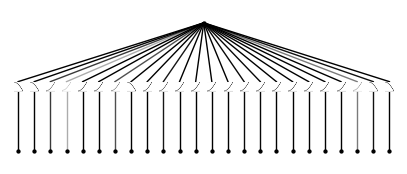

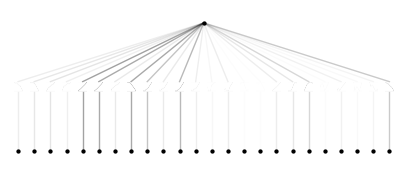

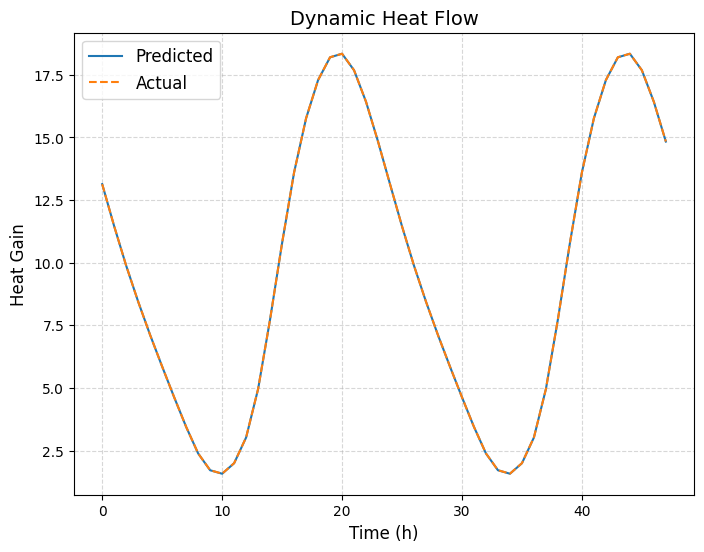

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 确保有 kan 模块

# 原始温度数据
temperatures = np.array([
    23.6, 23.3, 22.8, 22.5, 21.6, 21.6036, 22.08889, 25.57658, 26.88138,
    29.55627, 32.11253, 39.96427, 40.54804, 39.77658, 37.8, 34.32742, 35.07658,
    31.87538, 28.31471, 25.5, 24.6, 24, 23.7, 23.5
])

Heat_gain = np.array([
    13.13417462, 11.45466848, 9.88092101, 8.44516898, 7.11001838, 5.85620446,
    4.6322065, 3.4494772, 2.3910986, 1.72081328, 1.58218798, 2.00155233,
    3.03068612, 4.96438852, 7.74338952, 10.78902253, 13.60305654, 15.76344484,
    17.2882535, 18.20046696, 18.34008677, 17.682225, 16.42127091, 14.83681394
])

temperatures = np.tile(temperatures, 3)
Heat_gain = np.tile(Heat_gain, 3)



# 将温度数据转换为DataFrame
data = pd.DataFrame({'temperatures': temperatures})

# 调整滞后特征数量
N = 24  # 例如将滞后特征减少一半，确保有足够的数据点

# 生成时滞数据
for lag in range(1, N+1):
    data[f'Otemperatures_lag_{lag}'] = data['temperatures'].shift(lag)

# 删除因为时滞而产生的NaN行
data.dropna(inplace=True)

# 检查 data 是否仍然有效
if data.empty:
    print("Data is still empty after dropna(), consider further reducing lag value or modify data handling.")
else:
    # 继续后续处理
    input_features = [f'Otemperatures_lag_{i}' for i in range(1, N+1)]
    x_data = data[input_features].values  # 输入数据
    y_data = Heat_gain[:len(x_data)]  # 修正输出数据的长度以匹配输入数据

    # 后续的代码
    # Normalize the data
    x_mean = np.mean(x_data, axis=0)
    x_std = np.std(x_data, axis=0) + 1e-8
    x_data_norm = (x_data - x_mean) / x_std
    y_mean = np.mean(y_data)
    y_std = np.std(y_data) + 1e-8
    y_data_norm = (y_data - y_mean) / y_std

    # Convert to tensors
    x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)


# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize KAN with adjusted parameters
model = KAN(width=[x_data.shape[1], 1], grid=20, k=5, seed=0)

# Plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}')    

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')



# Train the model with early stopping and learning rate scheduling
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)



#Plot trained KAN
model.plot()
#Automatically set activation functions to be symbolic
# lib = ['x', 'sin', 'exp']
lib = ['x']
model.auto_symbolic(lib=lib)



#Continue training to almost machine precision
train_kan_with_early_stopping(model, dataset, steps=20000, patience=10)




# Obtain the symbolic formula in terms of normalized data
symbolic_formula_normalized = model.symbolic_formula()[0][0]

# Reverse normalization for symbolic formula using sympy
x_sym = symbols('x')
normalized_formula = sympify(symbolic_formula_normalized)

# 将公式恢复到原始数据尺度
original_formula = []
for i in range(len(x_std)):
    formula = normalized_formula.subs(x_sym, (x_sym * x_std[i]) + x_mean[i])
    original_formula.append(formula * y_std + y_mean)

# 打印恢复的符号公式
print("Discovered Symbolic Formulas (Original):")
for formula in original_formula:
    print(formula)


# Plotting and saving results
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

predicted_heat_gain = model(x_tensor).detach().numpy().flatten() * y_std + y_mean


# 生成与 x_data 长度相同的 x
x = np.linspace(0, len(predicted_heat_gain) - 1, num=len(predicted_heat_gain))

Heat_gain_trimmed = Heat_gain[:len(predicted_heat_gain)]

# 绘图
plt.figure()
plt.plot(x, predicted_heat_gain, label='Predicted')
plt.plot(x, Heat_gain_trimmed, label='Actual', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('Heat Gain')
plt.title('Dynamic Heat Flow')
plt.legend()
plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()




Step [1/200], Val Loss: 1.7120
Step [2/200], Val Loss: 1.7070
Step [3/200], Val Loss: 1.7019
Step [4/200], Val Loss: 1.6969
Step [5/200], Val Loss: 1.6918
Step [6/200], Val Loss: 1.6868
Step [7/200], Val Loss: 1.6817
Step [8/200], Val Loss: 1.6767
Step [9/200], Val Loss: 1.6717
Step [10/200], Val Loss: 1.6667
Step [11/200], Val Loss: 1.6617
Step [12/200], Val Loss: 1.6567
Step [13/200], Val Loss: 1.6517
Step [14/200], Val Loss: 1.6468
Step [15/200], Val Loss: 1.6418
Step [16/200], Val Loss: 1.6369
Step [17/200], Val Loss: 1.6319
Step [18/200], Val Loss: 1.6270
Step [19/200], Val Loss: 1.6221
Step [20/200], Val Loss: 1.6172
Step [21/200], Val Loss: 1.6122
Step [22/200], Val Loss: 1.6073
Step [23/200], Val Loss: 1.6025
Step [24/200], Val Loss: 1.5976
Step [25/200], Val Loss: 1.5927
Step [26/200], Val Loss: 1.5879
Step [27/200], Val Loss: 1.5830
Step [28/200], Val Loss: 1.5782
Step [29/200], Val Loss: 1.5733
Step [30/200], Val Loss: 1.5685
Step [31/200], Val Loss: 1.5637
Step [32/200], Va

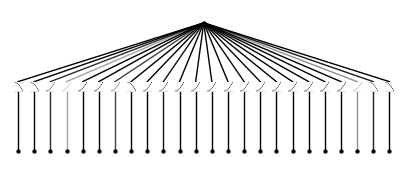

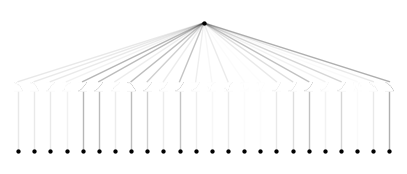

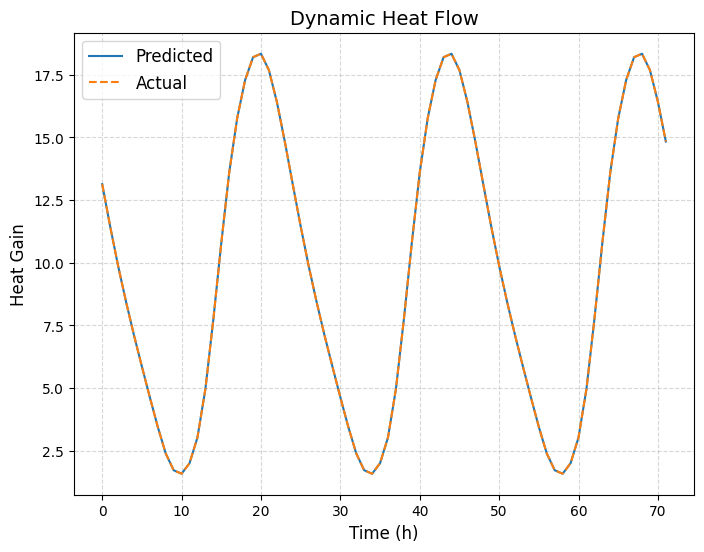

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 确保有 kan 模块

# 原始温度数据
temperatures = np.array([
    23.6, 23.3, 22.8, 22.5, 21.6, 21.6036, 22.08889, 25.57658, 26.88138,
    29.55627, 32.11253, 39.96427, 40.54804, 39.77658, 37.8, 34.32742, 35.07658,
    31.87538, 28.31471, 25.5, 24.6, 24, 23.7, 23.5
])

Heat_gain = np.array([
    13.13417462, 11.45466848, 9.88092101, 8.44516898, 7.11001838, 5.85620446,
    4.6322065, 3.4494772, 2.3910986, 1.72081328, 1.58218798, 2.00155233,
    3.03068612, 4.96438852, 7.74338952, 10.78902253, 13.60305654, 15.76344484,
    17.2882535, 18.20046696, 18.34008677, 17.682225, 16.42127091, 14.83681394
])



temperatures = np.tile(temperatures, 4)
Heat_gain = np.tile(Heat_gain, 4)



# 将温度数据转换为DataFrame
data = pd.DataFrame({'temperatures': temperatures})

# 调整滞后特征数量
N = 24  # 例如将滞后特征减少一半，确保有足够的数据点

# 生成时滞数据
for lag in range(1, N+1):
    data[f'Otemperatures_lag_{lag}'] = data['temperatures'].shift(lag)

# 删除因为时滞而产生的NaN行
data.dropna(inplace=True)

# 检查 data 是否仍然有效
if data.empty:
    print("Data is still empty after dropna(), consider further reducing lag value or modify data handling.")
else:
    # 继续后续处理
    input_features = [f'Otemperatures_lag_{i}' for i in range(1, N+1)]
    x_data = data[input_features].values  # 输入数据
    y_data = Heat_gain[:len(x_data)]  # 修正输出数据的长度以匹配输入数据

    # 后续的代码
    # Normalize the data
    x_mean = np.mean(x_data, axis=0)
    x_std = np.std(x_data, axis=0) + 1e-8
    x_data_norm = (x_data - x_mean) / x_std
    y_mean = np.mean(y_data)
    y_std = np.std(y_data) + 1e-8
    y_data_norm = (y_data - y_mean) / y_std

    # Convert to tensors
    x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)


# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize KAN with adjusted parameters
model = KAN(width=[x_data.shape[1], 1], grid=20, k=5, seed=0)

# Plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}')    

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')



# Train the model with early stopping and learning rate scheduling
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)



#Plot trained KAN
model.plot()
#Automatically set activation functions to be symbolic
# lib = ['x', 'sin', 'exp']
lib = ['x']
model.auto_symbolic(lib=lib)



#Continue training to almost machine precision
train_kan_with_early_stopping(model, dataset, steps=20000, patience=10)




# Obtain the symbolic formula in terms of normalized data
symbolic_formula_normalized = model.symbolic_formula()[0][0]

# Reverse normalization for symbolic formula using sympy
x_sym = symbols('x')
normalized_formula = sympify(symbolic_formula_normalized)

# 将公式恢复到原始数据尺度
original_formula = []
for i in range(len(x_std)):
    formula = normalized_formula.subs(x_sym, (x_sym * x_std[i]) + x_mean[i])
    original_formula.append(formula * y_std + y_mean)

# 打印恢复的符号公式
print("Discovered Symbolic Formulas (Original):")
for formula in original_formula:
    print(formula)


# Plotting and saving results
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

predicted_heat_gain = model(x_tensor).detach().numpy().flatten() * y_std + y_mean


# 生成与 x_data 长度相同的 x
x = np.linspace(0, len(predicted_heat_gain) - 1, num=len(predicted_heat_gain))

Heat_gain_trimmed = Heat_gain[:len(predicted_heat_gain)]

# 绘图
plt.figure()
plt.plot(x, predicted_heat_gain, label='Predicted')
plt.plot(x, Heat_gain_trimmed, label='Actual', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('Heat Gain')
plt.title('Dynamic Heat Flow')
plt.legend()
plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()




Step [1/200], Val Loss: 2.6653
Step [2/200], Val Loss: 2.6582
Step [3/200], Val Loss: 2.6512
Step [4/200], Val Loss: 2.6442
Step [5/200], Val Loss: 2.6372
Step [6/200], Val Loss: 2.6302
Step [7/200], Val Loss: 2.6232
Step [8/200], Val Loss: 2.6162
Step [9/200], Val Loss: 2.6092
Step [10/200], Val Loss: 2.6023
Step [11/200], Val Loss: 2.5953
Step [12/200], Val Loss: 2.5884
Step [13/200], Val Loss: 2.5815
Step [14/200], Val Loss: 2.5746
Step [15/200], Val Loss: 2.5677
Step [16/200], Val Loss: 2.5608
Step [17/200], Val Loss: 2.5539
Step [18/200], Val Loss: 2.5470
Step [19/200], Val Loss: 2.5402
Step [20/200], Val Loss: 2.5333
Step [21/200], Val Loss: 2.5265
Step [22/200], Val Loss: 2.5197
Step [23/200], Val Loss: 2.5129
Step [24/200], Val Loss: 2.5061
Step [25/200], Val Loss: 2.4993
Step [26/200], Val Loss: 2.4925
Step [27/200], Val Loss: 2.4858
Step [28/200], Val Loss: 2.4790
Step [29/200], Val Loss: 2.4723
Step [30/200], Val Loss: 2.4656
Step [31/200], Val Loss: 2.4589
Step [32/200], Va

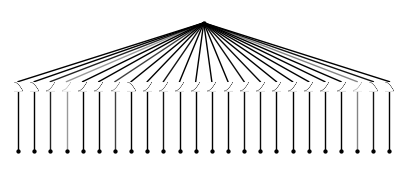

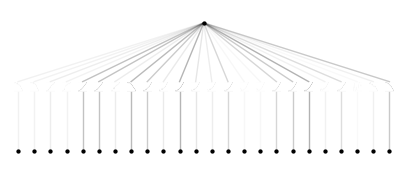

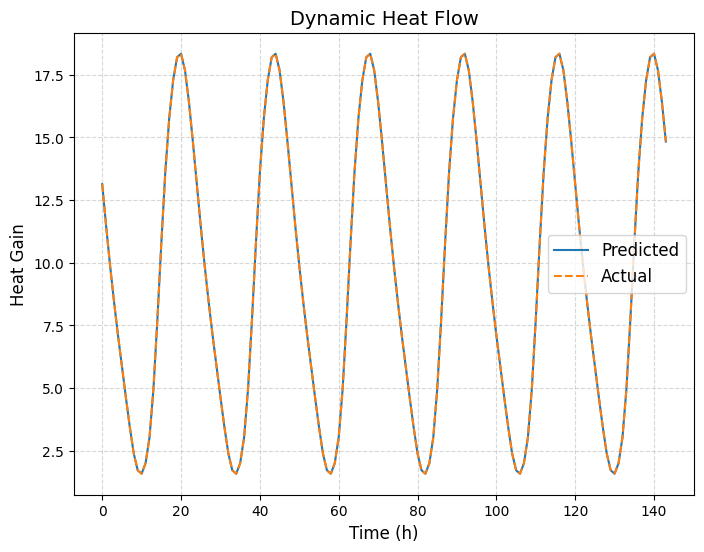

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 确保有 kan 模块

# 原始温度数据
temperatures = np.array([
    23.6, 23.3, 22.8, 22.5, 21.6, 21.6036, 22.08889, 25.57658, 26.88138,
    29.55627, 32.11253, 39.96427, 40.54804, 39.77658, 37.8, 34.32742, 35.07658,
    31.87538, 28.31471, 25.5, 24.6, 24, 23.7, 23.5
])

Heat_gain = np.array([
    13.13417462, 11.45466848, 9.88092101, 8.44516898, 7.11001838, 5.85620446,
    4.6322065, 3.4494772, 2.3910986, 1.72081328, 1.58218798, 2.00155233,
    3.03068612, 4.96438852, 7.74338952, 10.78902253, 13.60305654, 15.76344484,
    17.2882535, 18.20046696, 18.34008677, 17.682225, 16.42127091, 14.83681394
])



temperatures = np.tile(temperatures, 7)
Heat_gain = np.tile(Heat_gain, 7)



# 将温度数据转换为DataFrame
data = pd.DataFrame({'temperatures': temperatures})

# 调整滞后特征数量
N = 24  # 例如将滞后特征减少一半，确保有足够的数据点

# 生成时滞数据
for lag in range(1, N+1):
    data[f'Otemperatures_lag_{lag}'] = data['temperatures'].shift(lag)

# 删除因为时滞而产生的NaN行
data.dropna(inplace=True)

# 检查 data 是否仍然有效
if data.empty:
    print("Data is still empty after dropna(), consider further reducing lag value or modify data handling.")
else:
    # 继续后续处理
    input_features = [f'Otemperatures_lag_{i}' for i in range(1, N+1)]
    x_data = data[input_features].values  # 输入数据
    y_data = Heat_gain[:len(x_data)]  # 修正输出数据的长度以匹配输入数据

    # 后续的代码
    # Normalize the data
    x_mean = np.mean(x_data, axis=0)
    x_std = np.std(x_data, axis=0) + 1e-8
    x_data_norm = (x_data - x_mean) / x_std
    y_mean = np.mean(y_data)
    y_std = np.std(y_data) + 1e-8
    y_data_norm = (y_data - y_mean) / y_std

    # Convert to tensors
    x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
    y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)


# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Initialize KAN with adjusted parameters
model = KAN(width=[x_data.shape[1], 1], grid=20, k=5, seed=0)

# Plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100)

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}')    

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')



# Train the model with early stopping and learning rate scheduling
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)



#Plot trained KAN
model.plot()
#Automatically set activation functions to be symbolic
# lib = ['x', 'sin', 'exp']
lib = ['x']
model.auto_symbolic(lib=lib)



#Continue training to almost machine precision
train_kan_with_early_stopping(model, dataset, steps=20000, patience=10)




# Obtain the symbolic formula in terms of normalized data
symbolic_formula_normalized = model.symbolic_formula()[0][0]

# Reverse normalization for symbolic formula using sympy
x_sym = symbols('x')
normalized_formula = sympify(symbolic_formula_normalized)

# 将公式恢复到原始数据尺度
original_formula = []
for i in range(len(x_std)):
    formula = normalized_formula.subs(x_sym, (x_sym * x_std[i]) + x_mean[i])
    original_formula.append(formula * y_std + y_mean)

# 打印恢复的符号公式
print("Discovered Symbolic Formulas (Original):")
for formula in original_formula:
    print(formula)


# Plotting and saving results
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

predicted_heat_gain = model(x_tensor).detach().numpy().flatten() * y_std + y_mean


# 生成与 x_data 长度相同的 x
x = np.linspace(0, len(predicted_heat_gain) - 1, num=len(predicted_heat_gain))

Heat_gain_trimmed = Heat_gain[:len(predicted_heat_gain)]

# 绘图
plt.figure()
plt.plot(x, predicted_heat_gain, label='Predicted')
plt.plot(x, Heat_gain_trimmed, label='Actual', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('Heat Gain')
plt.title('Dynamic Heat Flow')
plt.legend()
plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()


